In [ ]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [1]:
%cd '/content/drive/MyDrive/Cov19/input'

/content/drive/MyDrive/Cov19/input


In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, add, multiply
from keras.layers import Multiply, UpSampling2D, core
from keras.layers.merge import concatenate
from keras.layers.core import Lambda
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology as morph
from skimage import measure

# 1. Loading data


In [3]:
with open('Processed_Data.cp', 'rb') as myfile:
  data = pickle.load(myfile)
all_cts = tf.cast(data['cts'], dtype=tf.float64)
all_lungs = tf.cast(data['lungs'], dtype=tf.double)
all_inf = tf.cast(data['infects'], dtype=tf.double)

In [4]:
print(all_cts.shape)
print(all_lungs.shape)
print(all_inf.shape)


(1564, 128, 128, 1)
(1564, 128, 128, 1)
(1564, 128, 128, 1)


# 2. Splitting data into training and validation sets

In [5]:
train_size = int(0.9*all_cts.shape[0])
X_train, yl_train, yi_train = (all_cts[:train_size]/255, all_lungs[:train_size], all_inf[:train_size])
X_valid, yl_valid, yi_valid = (all_cts[train_size:]/255, all_lungs[train_size:], all_inf[train_size:])
print(X_train.shape, yl_train.shape, yi_train.shape)
print(X_valid.shape, yl_valid.shape, yi_valid.shape)

(1407, 128, 128, 1) (1407, 128, 128, 1) (1407, 128, 128, 1)
(157, 128, 128, 1) (157, 128, 128, 1) (157, 128, 128, 1)


# 3. Define evaluation metrics
We will use dice coefficient as a metric for infection segmentation. Dice coefficient is (2TP/2TP+FN+FP) where TP, FN and FP correspond to true positive, false negative and false positive. Code taken from
https://medium.com/@karan_jakhar/100-days-of-code-day-7-84e4918cb72c

In [10]:
def dice(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_loss(y_true, y_pred):
  loss = 1 - dice(y_true, y_pred)
  return loss

def bce_dice_loss(y_true, y_pred):
  loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
  return loss

class CosineAnnealingLearningRateSchedule(callbacks.Callback):
  def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
    self.epochs = n_epochs
    self.cycles = n_cycles
    self.lr_max = lrate_max
    self.lrates = list()

  def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = np.floor(n_epochs/n_cycles)
    cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lrate_max/2 * (np.cos(cos_inner) + 1)

  def on_epoch_begin(self, epoch, logs=None):
    lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
    K.set_value(self.model.optimizer.lr, lr)
    self.lrates.append(lr)

# 4. CNN
For infection segmentation we will use attention model "UNet on Steroid" xD. For more information regarding activation function refer this 

In [23]:
def block1 (input_shape, filtersize, poolsz=(2,2)) :
    x = Conv2D(filtersize, (3,3), activation='relu', padding='same', kernel_initializer="he_normal") (input_shape)
    x = Conv2D(filtersize, (3,3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization()(x)
    x = MaxPooling2D(poolsz) (x_inter) 
    x = Dropout(0.2)(x) 
    return x, x_inter

def block2 (input_shape, filtersize) :
    x = BatchNormalization() (input_shape)
    x = Conv2D(filtersize, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
    x = Conv2D(filtersize, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x) 
    return x

In [26]:
def infection_segmentation(input_shape) :
  x_input = Input(input_shape)

  x, Xa = block1(x_input, 32)
  x, Xb = block1(x, 64)
  x, _ = block1(x, 128, poolsz=(1,1))
  x, _ = block1(x, 256, poolsz=(1,1))
  x = block2(x, 256)

  x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x)
  x = block2(x, 128)

  x = Conv2DTranspose(64, (2, 2), padding='same') (x)
  x = concatenate([x, Xb])
  x = block2(x, 64)

  x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x)
  x = concatenate([x, Xa], axis=3)
  x = block2(x, 32)

  infection_segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='infect_output') (x)

  model = Model(inputs=x_input, outputs=infection_segmentation, name='cts_model')
    
  return model

strategy = tf.distribute.MirroredStrategy()
with strategy.scope() :
    infection_segmentation = infection_segmentation(all_cts.shape[1:])

infection_segmentation.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "cts_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 32) 320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128, 128, 32) 128         conv2d_40[0][0]       

In [28]:
epochs = 100
lrmax = 5e-5
n_cycles = epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(epochs, n_cycles, lrmax)
checkpoint_fpath = "infection_segmentation_weights.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_dice', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

batch_size = 8
optim = optimizers.Adam(lr=5e-5, beta_1=0.9, beta_2=0.99)
with strategy.scope() :
    infection_segmentation.compile(optimizer=optim, loss=bce_dice_loss, metrics=[dice])

# 5. Train Model

In [29]:
infection_segmentation_res = infection_segmentation.fit(x = X_train, 
                            y = yi_train,
                            batch_size = batch_size, 
                            epochs = epochs,
                            verbose = 1,
                            validation_data = (X_valid, yi_valid),
                            callbacks = [cts_checkpoint_cb, lr_cb])

Epoch 1/100
176/176 [==============================] - 21s 85ms/step - loss: 0.6397 - dice: 0.0996 - val_loss: 0.7386 - val_dice: 0.0148

Epoch 00001: val_dice improved from -inf to 0.01479, saving model to infection_segmentation_weights.hdf5
Epoch 2/100
176/176 [==============================] - 12s 69ms/step - loss: 0.2937 - dice: 0.5016 - val_loss: 0.6998 - val_dice: 0.1607

Epoch 00002: val_dice improved from 0.01479 to 0.16071, saving model to infection_segmentation_weights.hdf5
Epoch 3/100
176/176 [==============================] - 12s 69ms/step - loss: 0.2552 - dice: 0.5744 - val_loss: 0.6471 - val_dice: 0.2577

Epoch 00003: val_dice improved from 0.16071 to 0.25769, saving model to infection_segmentation_weights.hdf5
Epoch 4/100
176/176 [==============================] - 12s 68ms/step - loss: 0.2360 - dice: 0.6137 - val_loss: 0.4948 - val_dice: 0.4248

Epoch 00004: val_dice improved from 0.25769 to 0.42480, saving model to infection_segmentation_weights.hdf5
Epoch 5/100
176/176

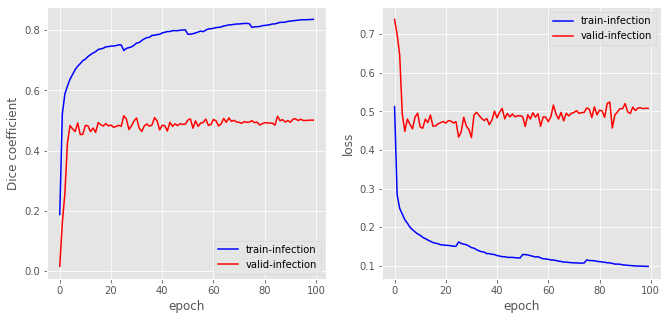

In [30]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(infection_segmentation_res.history['dice'], color='b', label='train-infection')
axes[0].plot(infection_segmentation_res.history['val_dice'], color='r', label='valid-infection')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()

axes[1].plot(infection_segmentation_res.history['loss'], color='b', label='train-infection')
axes[1].plot(infection_segmentation_res.history['val_loss'], color='r', label='valid-infection')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend();

# 6. Saving loads

In [31]:
infection_segmentation.load_weights("infection_segmentation_weights.hdf5")
with tf.device('/cpu:0') :
    pred_infs = infection_segmentation.predict(all_cts/255, batch_size=512)
print(all_cts.shape, pred_infs.shape)

(1564, 128, 128, 1) (1564, 128, 128, 1)


# 7. Visualize

In [39]:
def plot_lung_seg(all_cts, all_lungs, all_inf, pred_infs, axes) :

    axes[0].imshow(all_cts[:,:,0], cmap='bone')
    axes[0].set_title('CT image'); plt.grid(None)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    
    axes[1].imshow(all_lungs[:,:,0], cmap='bone')
    axes[1].imshow(all_inf[:,:,0], alpha=0.5, cmap='Reds')
    axes[1].set_title('Infection mask'); plt.grid(None)
    axes[1].set_xticks([]); axes[1].set_yticks([])

    axes[2].imshow(all_lungs[:,:,0], cmap='bone')
    axes[2].imshow(pred_infs[:,:,0], alpha=0.5, cmap='Reds')
    axes[2].set_title('pred Infection mask'); plt.grid(None)
    axes[2].set_xticks([]); axes[2].set_yticks([])

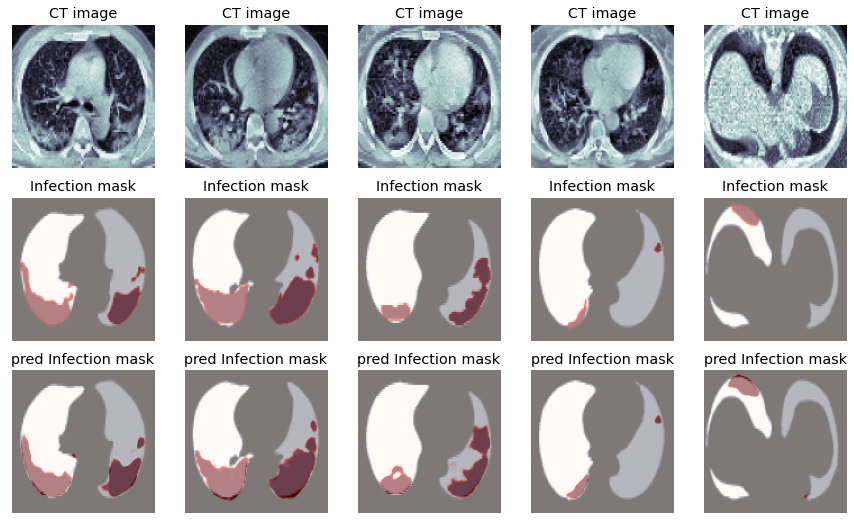

In [43]:
import random
indices = random.choices(range(len(pred_infs)), k=5)
fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ii, idx in enumerate(indices) :
    plot_lung_seg(all_cts[idx], all_lungs[idx], all_inf[idx], pred_infs[idx], list(axes[:,ii]))